In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import random

In [2]:
training_challenge_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json'))
training_solutions_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_solutions.json'))

In [3]:
# find random keys from the training_challenge_dict
random_keys = list(training_challenge_dict.keys())
n = random.randint(0, len(random_keys))

## Difficult problems
- a64e4611
- cbded52d
- 508bd3b6


Challenge key: 8e1813be


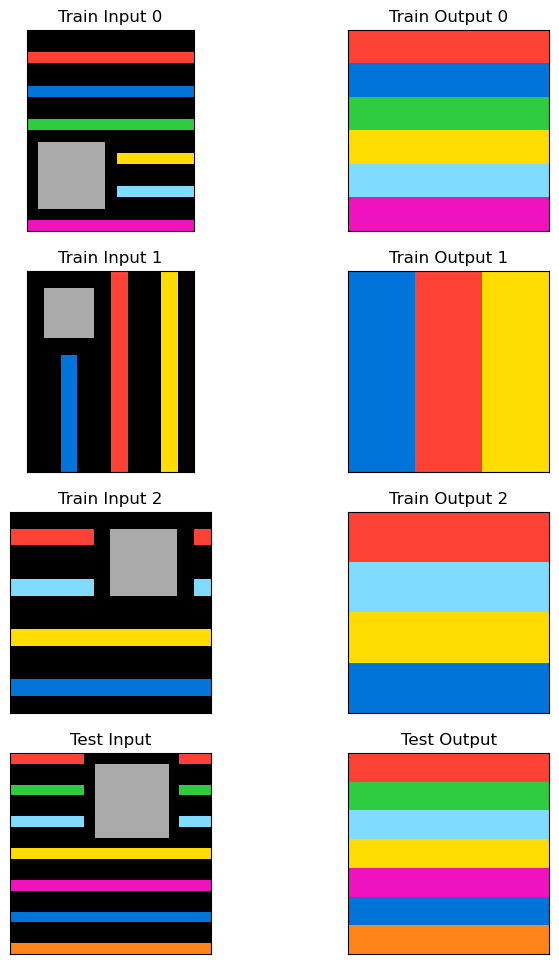

In [4]:
# import the display_challenge function
from dsl.utilities.plot import display_challenge, plot_grid

# find the first challenge and solution
challenge_key = '1f85a75f'
challenge_key = random_keys[n]
first_challenge = training_challenge_dict[challenge_key]
first_solution = training_solutions_dict[challenge_key]

print(f'Challenge key: {challenge_key}')

# display the challenge
display_challenge(challenge_key)

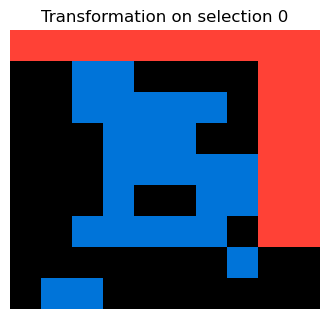

In [5]:
arr = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plot_grid(arr)

In [6]:
from dsl.color_select import ColorSelector

colsel = ColorSelector()

popular_color = colsel.mostcolor(arr)
print(f'Most popular color: {popular_color}')
least_popular_color = colsel.leastcolor(arr)
print(f'Least popular color: {least_popular_color}')

second_most_popular_color = colsel.rankcolor(arr, 1)
print(f'Second most popular color: {second_most_popular_color}')

color_of_second_biggest_shape = colsel.rank_largest_shape_color_nodiag(arr, 1)
print(f'Color of second biggest shape: {color_of_second_biggest_shape}')

color_of_second_biggest_shape = colsel.rank_largest_shape_color_diag(arr, 1)
print(f'Color of second biggest shape: {color_of_second_biggest_shape}')

Most popular color: 0
Least popular color: 2
Second most popular color: 1
Color of second biggest shape: 1
Color of second biggest shape: 1


Selecting by color


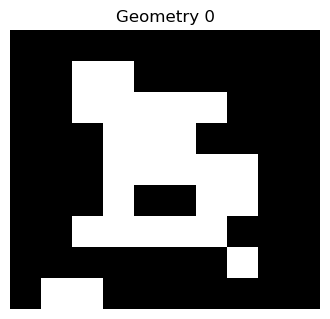

Selecting colored rectange combinations


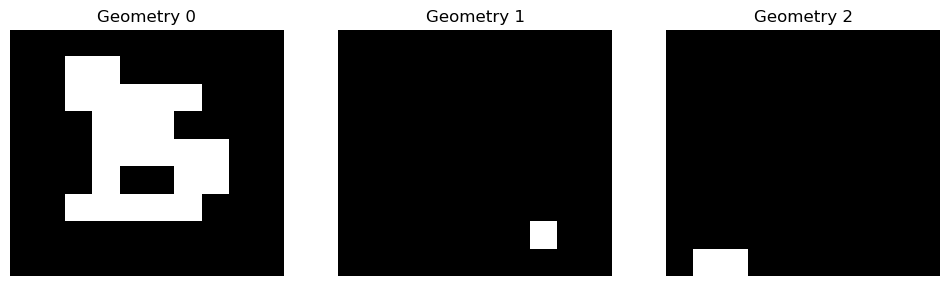

Selecting cells adjacent to color


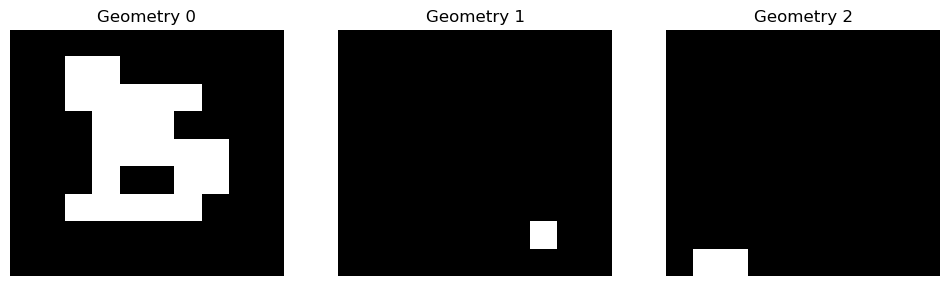

In [7]:
from dsl.select import Selector
from dsl.utilities.plot import plot_selection
from skimage.segmentation import find_boundaries

sel = Selector(arr.shape)

print('Selecting by color')
selection = sel.select_color(arr, 1)
plot_selection(selection)

print('Selecting colored rectange combinations')
selection3 = sel.select_connected_shapes(arr, 1)
plot_selection(selection3)

print('Selecting cells adjacent to color')
selection4 = sel.select_connected_shapes(arr, 1)
plot_selection(selection4)

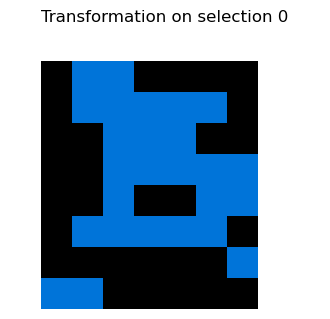

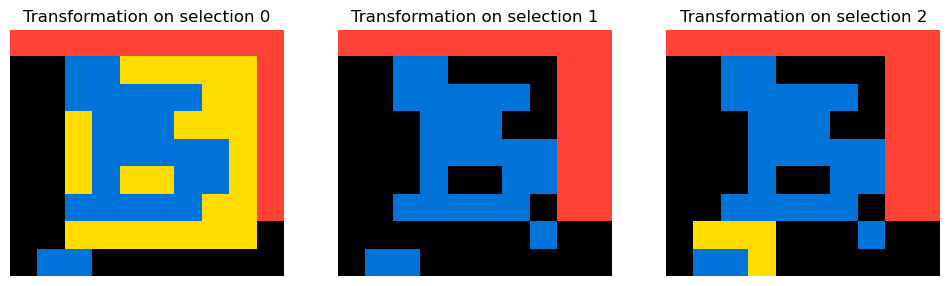

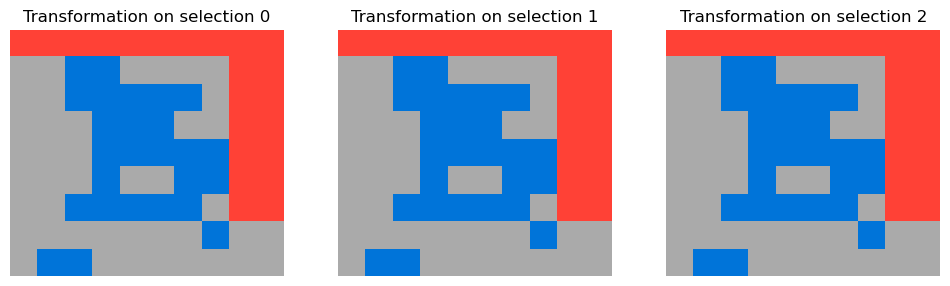

Mirroring horizontally


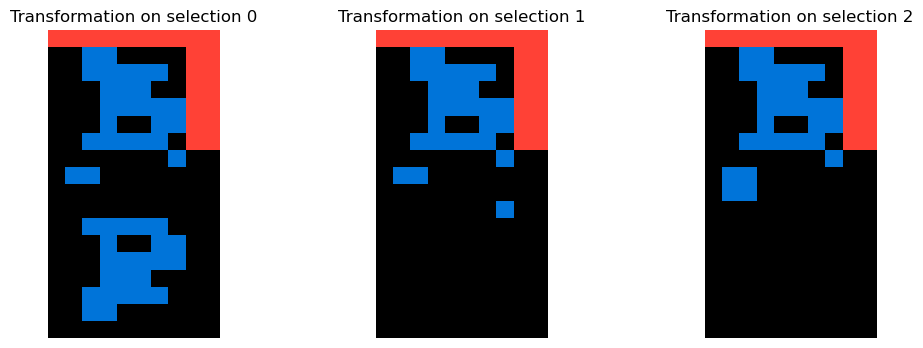

In [ ]:
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d

trn = Transformer()

transformed = trn.crop(arr, selection)
plot_grid_3d(transformed)

transformed3 = trn.fill_bounding_square_with_color(arr, selection3, 4)
plot_grid_3d(transformed3)

transformed3 = trn.change_background_color(arr, selection3, 5)
plot_grid_3d(transformed3)

print('Mirroring horizontally')
transformed4 = trn.duplicate_horizontally(arr, selection4)
plot_grid_3d(transformed4)

In [9]:
from scipy.ndimage import label

arr = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 2],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

labels, nlabels = label(arr)
print(labels)


[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 1 1 0 0]
 [0 0 0 1 0 0 1 1 0 2]
 [0 0 1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 4 4 0 0 0 0 0 0 0]]


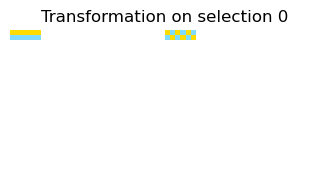

In [10]:
from enviroment import ARCEnviroment

env = ARCEnviroment(training_challenge_dict)
grid = env.get_random_challenge()
plot_grid(grid)

In [11]:
import numpy as np

def enlarge(grid, selection, radius):
    """
    Enlarges the selected shape in the grid by a given radius, adding rows and columns of zeros between existing rows and columns.
    
    Args:
        grid (np.ndarray): The original input grid
        selection (np.ndarray): A binary mask indicating the shape (same shape as grid)
        radius (int): Number of cells to expand outward
        
    Returns:
        np.ndarray: A new grid with the enlarged shape
    #TODO: In the DRL environment radius will probably have to be an iterable for low numbers (likely between 1 and 3)
    """
    # Ensure grid and selection are the same shape
    assert grid.shape == selection.shape, "Grid and each selection layer must have the same shape."
    
    rows, cols = grid.shape
    # Create a larger grid with interstitial spaces
    new_rows = rows * 2 - 1
    new_cols = cols * 2 - 1
    
    # Add padding for the expansion
    pad_rows = radius
    pad_cols = radius
    total_rows = new_rows + 2 * pad_rows
    total_cols = new_cols + 2 * pad_cols
    
    # Create padded grid with zeros
    padded_grid = np.zeros((total_rows, total_cols), dtype=grid.dtype)
    padded_selection = np.zeros((total_rows, total_cols), dtype=selection.dtype)
    
    
    # Fill original positions (accounting for padding offset)
    for i in range(rows):
        for j in range(cols):
            if selection[i, j] == 1 and grid[i, j] == 1:
                padded_grid[pad_rows + i*2, pad_cols + j*2] = 1
                padded_selection[pad_rows + i*2, pad_cols + j*2] = 1
    
    # Find all non-zero elements in the grid (enlargement origins)
    enlargement_origins = np.argwhere(padded_grid != 0)

    # Iterate over each origin
    for origin in enlargement_origins:
        row, col = origin

        # Vertical (upwards)
        for r in range(1, radius + 1):
            if row - r >= 0:  # Ensure we don't go out of bounds
                padded_grid[row - r, col] = 1

        # Horizontal (rightwards)
        for c in range(1, radius + 1):
            if col + c < padded_grid.shape[1]:  # Ensure we don't go out of bounds
                padded_grid[row, col + c] = 1

        # Diagonal (right-up)
        for d in range(1, radius + 1):
            if row - d >= 0 and col + d < padded_grid.shape[1]:  # Ensure we don't go out of bounds
                padded_grid[row - d, col + d] = 1

    return padded_grid


# Test the function
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
])

selection = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
])

# Enlarge the selection with a radius of 1 and include diagonal neighbors
result = enlarge(grid, selection, radius=1)

# Print results
print("\nOriginal Grid:")
print(grid)
print("\nEnlarged Grid:")
print(result)




Original Grid:
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [1 1 0 0 0 0]
 [1 1 0 0 0 0]]

Enlarged Grid:
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [12]:
import numpy as np

def downscale(grid, scale_factor, aggregation_fn=np.max):
    """
    Downscales a grid by a given scale factor using a specified aggregation function.
    
    Args:
        grid (np.ndarray): The input grid to downscale.
        scale_factor (int): The factor by which to reduce the grid's size.
        aggregation_fn (callable): The function to aggregate values in each block (default: np.max).
    
    Returns:
        np.ndarray: The downscaled grid.
    """
    assert grid.shape[0] % scale_factor == 0 and grid.shape[1] % scale_factor == 0, \
        "Grid dimensions must be divisible by scale_factor."
    
    rows, cols = grid.shape
    new_rows = rows // scale_factor
    new_cols = cols // scale_factor

    # Create the downscaled grid
    downscaled_grid = np.zeros((new_rows, new_cols), dtype=grid.dtype)

    # Iterate over blocks and apply aggregation function
    for i in range(new_rows):
        for j in range(new_cols):
            block = grid[
                i * scale_factor:(i + 1) * scale_factor,
                j * scale_factor:(j + 1) * scale_factor
            ]
            downscaled_grid[i, j] = aggregation_fn(block)

    return downscaled_grid

# Test the function
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0]
])

selection = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0]
])

# Enlarge the selection with a radius of 1
result = downscale(grid, 3)

print("\nOriginal Grid:")
print(grid)
print("\nEnlarged Grid:")
print(result.astype(int))  # Convert to int for cleaner printing


AssertionError: Grid dimensions must be divisible by scale_factor.